#### Read Data

In [ ]:
import numpy as np

In [ ]:
# load data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
df = pandas.read_csv(url, names=names)
df.to_csv("diabetes data")

### Feature Transformation

##### Polynomial Based Data Transformation
Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import datasets
import pandas as pd

poly_features = PolynomialFeatures(degree = 2)

poly_data= poly_features.fit_transform(df[['plas', 'skin', 'test']])
feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(['plas', 'skin','test'],p) for p in poly_features.powers_]]
df2 = pd.DataFrame(data = poly_data, columns = feature_names)

In [ ]:
df2.head()

##### Numeric Variable Transformations - Log, square root, square, cube, exponential
##### Use transformations where applicable, since exp (example: e^2190), cube and squares can lead to large numbers and overflow issues

In [ ]:
numeric_column_names = ['plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
var = ''
for col in numeric_column_names:
    df[col + '_log1p'] = np.float32(np.log1p(df[col]))
#    df[col + '_log'] = np.float32(df[col].apply(lambda x: np.log(x) if x!=0 else np.nan))
    df[col + '_sqrt']= np.float32(np.sqrt(df[col]))
    df[col + '_sq']= np.float32(np.square(df[col]))
    df[col + '_cube']= np.float32(np.power(df[col],3))
#    df[col + '_exp']= np.float32(np.exp(df[col]))

### Feature Selection
    - Filter Methods
    - Wrapper Methods
    - Embedded Methods

##### Filter methods:
    - Variance Selection Method
    - Correlation coefficient
    - Chi-square test    
    - Information gain
    - Fisher score

Filter method uses the exact assessment criterion which includes information, distance, dependency, and consistency

<img src="Correlation.png">

##### Variance Selection Method
Using the variance selection method, the variance of each feature is first calculated, and then the feature whose variance is greater than the threshold is selected according to the threshold. The code for selecting features using the Variance Threshold class of the feature_selection library is as follows:

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=3)
var_threshold = selector.fit_transform(df)
df2 = pd.DataFrame(data = var_threshold, columns = df.columns[selector.get_support(indices=True)])

##### Correlation Coefficient Method 
(Continuos to Continuos - Linear Regression, choose the features with highest coefficients) 

In [ ]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr

kbest_cc = SelectKBest(lambda X, Y: np.array(list(map(lambda x:pearsonr(x, Y), X.T)))[:,0], k=4)
corr_coefs = kbest_cc.fit_transform(df.drop(['class'],axis = 1).values, df['class'].values)
print(kbest_cc.scores_)
df2 = pd.DataFrame(data = corr_coefs, columns = df.columns[kbest_cc.get_support(indices=True)])

##### Univariate Selection - SelectKBest (Using ChiSq Test Scoring)

Chi Sq test: To measure the correlation between categorical target variable (dependent) and categorical independent variables. Hence it is required that the input variables for Chi sq test are all non-negative features

In [ ]:
df.head()

In [ ]:
import pandas
import numpy
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
X_train = df.drop(['class'], axis = 1)
y_train = df['class']

categorical_fields = ['preg','skin', 'age']
kbest_chi = SelectKBest(score_func=chi2, k=1)
chi_fit = kbest_chi.fit_transform(X_train[categorical_fields], y_train)

np.set_printoptions(precision=3)
scores_df = pd.DataFrame(data = kbest_chi.scores_, columns = ['scores'], index = list(X_train[categorical_fields].columns))
X_train2 = pd.DataFrame(data = chi_fit, columns = X_train[categorical_fields].columns[kbest_chi.get_support(indices=True)])

##### SelectKBest (Using Mutual Information)
mutual_info_classif: Mutual information for a discrete target <br>
mutual_info_regression: Mutual information for a continuous target

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

kbest_MI = SelectKBest(score_func = mutual_info_classif, k=4)
MI_data = kbest_MI.fit_transform(df.drop(['class'],axis = 1).values, df['class'].values)
scores_df = pd.DataFrame(data = kbest_MI.scores_, columns = ['scores'], index = list(df.drop(['class'], axis = 1).columns))
df2 = pd.DataFrame(data = MI_data, columns = df.columns[kbest_MI.get_support(indices=True)])

#### Wrapper Methods for Feature Selection
###### - Recursive feature elimination
###### - Sequential feature selection algorithms (available only in mlxtend library?)
###### - Genetic algorithms

##### Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
from sklearn import ensemble, svm, linear_model, model_selection
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def plot_feature_importances(estimator, X, cutoff=40):
    if isinstance(estimator, linear_model.Lasso) :
        importances = estimator.coef_
    else:
        importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1][:cutoff]
    plt.figure()
    g = sns.barplot(y=X.columns[indices][:cutoff],x = importances[indices][:cutoff] , orient='h')
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title("Feature importances based on: " + str(estimator).split('(')[0] + ' model' )

In [ ]:
def grid_search_best_model(estimator, grid, X, y, cv=10, scoring='accuracy'):
    grid_estimator = model_selection.GridSearchCV(estimator, grid, scoring=scoring, cv=cv)
    grid_estimator.fit(X, y)
    best_est = grid_estimator.best_estimator_
    
    print("Best parameters:" + str(grid_estimator.best_params_) )
    print("Validation score:" + str(grid_estimator.best_score_) )
    print("Train score:" + str(grid_estimator.score(X, y)) )

    return best_est

##### Random Forest Wrapper - RFE

In [ ]:
X_train = df.drop(['class'], axis = 1)
y_train = df['class']
rf_estimator = ensemble.RandomForestClassifier(n_estimators = 50)

rf_grid  = {'max_depth':list(range(1,9)), 'n_estimators':list(range(1,300,100)) }
rf_final_estimator = grid_search_best_model(rf_estimator, rf_grid, X_train, y_train)

wrapper_selector = RFE(estimator = rf_estimator, n_features_to_select = 3, step = 1)
X_train1 = wrapper_selector.fit_transform(X_train, y_train)
print(wrapper_selector.support_)
print(wrapper_selector.ranking_)
plot_feature_importances(estimator = rf_final_estimator, X = X_train, cutoff = 40)

##### Gradient Boost Wrapper - RFE

In [ ]:
X_train = df.drop(['class'], axis = 1)
y_train = df['class']
gb_estimator = ensemble.GradientBoostingClassifier(n_estimators = 50)

gb_grid  = {'max_depth':list(range(1,9)), 'n_estimators':list(range(1,300,100)) }
gb_final_estimator = grid_search_best_model(gb_estimator, gb_grid, X_train, y_train)

wrapper_selector = RFE(gb_final_estimator, n_features_to_select = 3, step = 1)
X_train1 = wrapper_selector.fit_transform(X_train, y_train)
print(wrapper_selector.support_)
print(wrapper_selector.ranking_)
plot_feature_importances(estimator = gb_final_estimator, X = X_train, cutoff = 40)

##### SVM Wrapper - RFE

In [ ]:
X_train = df.drop(['class'], axis = 1)
y_train = df['class']
svm_estimator = svm.LinearSVC(max_iter = 6000)
wrapper_selector = RFE(svm_estimator, n_features_to_select = 2, step = 1)
X_train1 = wrapper_selector.fit_transform(X_train, y_train)
print(wrapper_selector.support_)
print(wrapper_selector.ranking_)

#### Embedded Methods
- Random Forest 
- Gradient Boost
- SVM
- L1 (LASSO) regularization

Best parameters:{'max_depth': 7, 'n_estimators': 101}
Validation score:0.7734375
Train score:0.9192708333333334


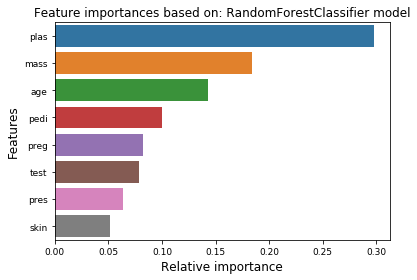

In [584]:
from sklearn.feature_selection import SelectFromModel
from sklearn import ensemble

rf_estimator = ensemble.RandomForestClassifier()
rf_grid  = {'max_depth':list(range(1,9)), 'n_estimators':list(range(1,300,100)) }
rf_final_estimator = grid_search_best_model(rf_estimator, rf_grid, X_train, y_train)
embedded_selector = SelectFromModel(rf_final_estimator, prefit=True, threshold='mean')
X_train1 = embedded_selector.transform(X_train)
plot_feature_importances(rf_final_estimator, X_train)

Best parameters:{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 150}
Validation score:0.7747395833333334
Train score:0.80078125


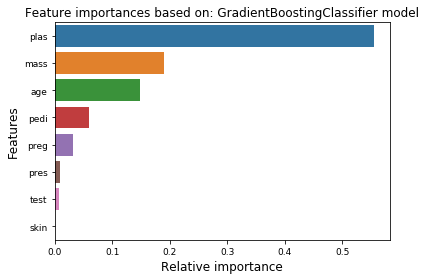

In [585]:
gb_estimator = ensemble.GradientBoostingClassifier()
gb_grid  = {'max_depth':[1,2,3], 'n_estimators':list(range(50,300, 100)), 'learning_rate':[0.001, 0.1, 1.0] }
gb_final_estimator = grid_search_best_model(gb_estimator, gb_grid, X_train, y_train)
embedded_selector = SelectFromModel(gb_final_estimator, prefit=True, threshold='mean')
X_train1 = embedded_selector.transform(X_train)
plot_feature_importances(gb_final_estimator, X_train)

In [ ]:
svm_estimator = svm.LinearSVC()
svm_grid = {'C':[0.01, 0.1, 1] }
svm_final_estimator = grid_search_best_model(svm_estimator, svm_grid, X_train, y_train)
embedded_selector = SelectFromModel(svm_final_estimator, prefit=True, threshold='mean')
X_train1 = embedded_selector.transform(X_train)
#LinearSVC' object has no attribute 'feature_importances_'

In [ ]:
# L1 regularizer
#X_train = df.drop(['class'], axis = 1)
#y_train = df['class']

#from sklearn.feature_selection import SelectFromModel
#from sklearn.linear_model import LogisticRegression

#GBDT as the feature selection of the base model
#embedded_Logistic_L1_selector = SelectFromModel(LogisticRegression(penalty="l1",C=0.1))
#temp = embedded_Logistic_L1_selector.fit_transform(X_train, y_train)

#### Dimensionality reduction
When the feature selection is completed, the model can be directly trained, but the feature matrix is ​​too large, resulting in a large amount of computation and a long training time. Therefore, it is also necessary to reduce the dimension of the feature matrix. Common dimensionality reduction methods In addition to the L1 penalty-based model mentioned above, there are principal component analysis (PCA) and linear discriminant analysis (LDA). Linear discriminant analysis itself is also a classification model. PCA and LDA have many similarities, the essence of which is to map the original sample to the lower-dimensional sample space, but the mapping target of PCA and LDA is different: PCA is to make the mapped sample have the largest divergence. LDA is designed to give the mapped sample the best classification performance . So PCA is an unsupervised dimensionality reduction method, and LDA is a supervised dimensionality reduction method.

##### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

#### NORMALIZE FEATURES BEFORE PUTTING THEM THROUGH PCA ####
#### Refer 03 Preprocessing for scaling
X_scaled = pd.DataFrame(preprocessing.scale(X_train),columns = X_train.columns)


n_components = len(X_scaled.columns)
pca = PCA(n_components=n_components)
X_transformed = pca.fit_transform(X_scaled)
pca_scoretable= pd.DataFrame(pca.components_,columns=X_scaled.columns,index = ["P-" + str(v) for v in range(1, n_components+1)])
print(pca.explained_variance_ratio_)  # Should sum to 1
print(pca.explained_variance_ratio_.cumsum())
print(pca.singular_values_)
pca_scoretable

##### LDA
LDA makes some simplifying assumptions about your data:

- That your data is Gaussian, that each variable is is shaped like a bell curve when plotted.<br>
- That each attribute has the same variance, that values of each variable vary around the mean by the same amount on average

- Classification Problems. This might go without saying, but LDA is intended for classification problems where the output variable is categorical. LDA supports both binary and multi-class classification.
- Gaussian Distribution. The standard implementation of the model assumes a Gaussian distribution of the input variables. Consider reviewing the univariate distributions of each attribute and using transforms to make them more Gaussian-looking (e.g. log and root for exponential distributions and Box-Cox for skewed distributions).
- Remove Outliers. Consider removing outliers from your data. These can skew the basic statistics used to separate classes in LDA such the mean and the standard deviation.
- Same Variance. LDA assumes that each input variable has the same variance. It is almost always a good idea to standardize your data before using LDA so that it has a mean of 0 and a standard deviation of 1.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing

#There is an argument tha scaling makes no different, validate it with model performance
scaler1 = preprocessing.StandardScaler()
X_scaler = pd.DataFrame(scaler1.fit_transform(X_train), columns = X_train.columns)
print(scaler1.scale_) #scale is sqrt of variance here
print(scaler1.var_)


# n_components : int, optional (default=None)
# Number of components (<= min(n_classes - 1, n_features)) for dimensionality reduction. If None, will be set to min(n_classes - 1, n_features).
clf = LinearDiscriminantAnalysis(n_components = 2)
X_transformed = clf.fit(X_scaler, y_train)

#X_scaler = pd.DataFrame(scaler1.fit_transform(iris.data))
#X_transformed = clf.fit(X_scaler, iris.target)


# explained_variance_ratio_ : array, shape (n_components,)
# Percentage of variance explained by each of the selected components. 
# If n_components is not set then all components are stored and the sum of explained variances is equal to 1.0. Only available when eigen or svd solver is used.

print(clf.explained_variance_ratio_)  # Should sum to 1,# elements = (number of classes - 1)
print(clf.explained_variance_ratio_.cumsum())

In [590]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')